In [54]:
# Import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [55]:
# date parser function for the specific date format
date_parser = lambda x: pd.to_datetime(x, format="%d-%m-%y %H:%M")

# Load the datasets
actual_generation = pd.read_excel(
    "Data/Market/actual_generation_hour.xlsx", 
    parse_dates=["Start date"], 
    date_format="%d-%m-%y %H:%M"
    ).set_index("Start date").drop(columns=["End date"])

actual_consumption = pd.read_excel(
    "Data/Market/actual_consumption_hour.xlsx",
    parse_dates=["Start date"], 
    date_format="%d-%m-%y %H:%M"
    ).set_index("Start date").drop(columns=["End date"])

forecasted_generation = pd.read_excel(
    "Data/Market/forecasted_generation_hour.xlsx",
    parse_dates=["Start date"],
    date_format="%d-%m-%y %H:%M"
    ).set_index("Start date").drop(columns=["End date"])

day_ahead_prices = pd.read_excel("Data/Market/day-ahead_prices_hour.xlsx",
    parse_dates=["Start date"],
    date_format="%d-%m-%y %H:%M"
    ).set_index("Start date").drop(columns=["End date"])

In [56]:
# Display the first few rows of each dataframe to verify the changes
actual_generation

,Biomass [MWh],Hydropower [MWh],Wind offshore [MWh],Wind onshore [MWh],Photovoltaics [MWh],Other renewable [MWh],Nuclear [MWh],Lignite [MWh],Hard coal [MWh],Fossil gas [MWh],Hydro pumped storage [MWh],Other conventional [MWh]
Start date,,,,,,,,,,,,
"Jan 1, 2023 12:00 AM",4365,1275.25,3059.25,28710.50,1.25,129.5,2459.5,3859.25,2067.5,1721.75,42.75,1228.75
"Jan 1, 2023 1:00 AM",4344.75,1226.5,3586.00,29305.00,1.00,129,2458.75,3866.5,2052,1568,126.75,1218.25
"Jan 1, 2023 2:00 AM",4333,1222.5,3842.25,29266.00,1.25,129,2459.75,3860.25,2034.25,1571.5,85.5,1211.5
"Jan 1, 2023 3:00 AM",4338.75,1223.25,3463.25,27008.50,1.00,129,2460.5,3864.75,2037,1564.75,84,1211.75
"Jan 1, 2023 4:00 AM",4353.25,1244,3462.25,26438.75,1.50,128.25,2461,3841,2040.25,1550.5,84,1214.25
...,...,...,...,...,...,...,...,...,...,...,...,...
"Oct 31, 2024 7:00 PM",4610.75,1908.75,3522.25,15330.25,0.00,92,-,10659.75,6776,9085.25,1503.75,982.75
"Oct 31, 2024 8:00 PM",4583.25,1587,3201.75,16392.00,0.00,92,-,9817.75,6050,8621.5,791,967.25
"Oct 31, 2024 9:00 PM",4540,1538.5,3220.00,17175.75,0.00,92,-,9168,5242.25,8070,397.25,961.5


In [57]:
actual_consumption.head()

,Total (grid load) [MWh],Residual load [MWh],Hydro pumped storage [MWh]
Start date,,,
"Jan 1, 2023 12:00 AM",38346.00,6575.00,2023
"Jan 1, 2023 1:00 AM",37777.25,4885.25,1682.5
"Jan 1, 2023 2:00 AM",36939.75,3830.25,3287.5
"Jan 1, 2023 3:00 AM",35932.50,5459.75,4015.75
"Jan 1, 2023 4:00 AM",35486.25,5583.75,4023.5


In [58]:
forecasted_generation.head()

,Total [MWh],Photovoltaics and wind [MWh],Wind offshore [MWh],Wind onshore [MWh],Photovoltaics [MWh],Other [MWh]
Start date,,,,,,
"Jan 1, 2023 12:00 AM",56012,38993.75,3478.25,35515.50,0.0,17018.25
"Jan 1, 2023 1:00 AM",56152,38734.75,3390.25,35344.50,0.0,17417.25
"Jan 1, 2023 2:00 AM",53669,38534.25,3395.50,35138.75,0.0,15134.75
"Jan 1, 2023 3:00 AM",52712,37851.25,3410.25,34441.00,0.0,14860.75
"Jan 1, 2023 4:00 AM",51940,37329.25,3431.25,33898.00,0.0,14610.75


In [59]:
day_ahead_prices.head()

,Germany/Luxembourg [€/MWh],∅ DE/LU neighbours [€/MWh],Belgium [€/MWh],Denmark 1 [€/MWh],Denmark 2 [€/MWh],France [€/MWh],Netherlands [€/MWh],Norway 2 [€/MWh],Austria [€/MWh],Poland [€/MWh],Sweden 4 [€/MWh],Switzerland [€/MWh],Czech Republic [€/MWh],DE/AT/LU [€/MWh],Northern Italy [€/MWh],Slovenia [€/MWh],Hungary [€/MWh]
Start date,,,,,,,,,,,,,,,,,
"Jan 1, 2023 12:00 AM",-5.17,13.85,-4.39,2.01,2.01,0.00,-3.61,119.32,12.06,18.09,2.01,0.03,4.84,-,195.90,13.31,19.76
"Jan 1, 2023 1:00 AM",-1.07,9.79,-1.75,1.38,1.38,-0.10,-1.46,108.83,-0.10,5.75,1.38,-7.25,-0.35,-,191.09,-0.07,0.19
"Jan 1, 2023 2:00 AM",-1.47,8.91,-1.46,0.09,0.09,-1.33,-1.52,102.39,-0.66,5.27,0.09,-3.99,-0.97,-,187.95,-0.47,0.07
"Jan 1, 2023 3:00 AM",-5.08,6.58,-5.27,0.08,0.08,-4.08,-5.00,92.36,-1.99,5.74,0.08,-7.71,-1.93,-,187.82,-1.56,0.01
"Jan 1, 2023 4:00 AM",-4.49,5.42,-4.41,0.05,0.05,-4.16,-4.60,82.66,-2.42,5.22,0.05,-9.71,-3.07,-,187.74,-1.94,-0.77


In [60]:
actual_generation.columns, actual_consumption.columns, forecasted_generation.columns, day_ahead_prices.columns

(Index(['Biomass [MWh]', 'Hydropower [MWh]', 'Wind offshore [MWh]',
        'Wind onshore [MWh]', 'Photovoltaics [MWh]', 'Other renewable [MWh]',
        'Nuclear [MWh]', 'Lignite [MWh]', 'Hard coal [MWh]', 'Fossil gas [MWh]',
        'Hydro pumped storage [MWh]', 'Other conventional [MWh]'],
       dtype='object'),
 Index(['Total (grid load) [MWh]', 'Residual load [MWh]',
        'Hydro pumped storage [MWh]'],
       dtype='object'),
 Index(['Total [MWh]', 'Photovoltaics and wind [MWh]', 'Wind offshore [MWh]',
        'Wind onshore [MWh]', 'Photovoltaics [MWh]', 'Other [MWh]'],
       dtype='object'),
 Index(['Germany/Luxembourg [€/MWh]', '∅ DE/LU neighbours [€/MWh]',
        'Belgium [€/MWh]', 'Denmark 1 [€/MWh]', 'Denmark 2 [€/MWh]',
        'France [€/MWh]', 'Netherlands [€/MWh]', 'Norway 2 [€/MWh]',
        'Austria [€/MWh]', 'Poland [€/MWh]', 'Sweden 4 [€/MWh]',
        'Switzerland [€/MWh]', 'Czech Republic [€/MWh]', 'DE/AT/LU [€/MWh]',
        'Northern Italy [€/MWh]', 'Sloveni

In [62]:
forecasted_generation.dtypes

Total [MWh]                      object
Photovoltaics and wind [MWh]    float64
Wind offshore [MWh]             float64
Wind onshore [MWh]              float64
Photovoltaics [MWh]             float64
Other [MWh]                      object
dtype: object

In [63]:
for col in forecasted_generation.columns:
    forecasted_generation[col] = pd.to_numeric(forecasted_generation[col], errors='coerce')

forecasted_generation.dtypes

Total [MWh]                     float64
Photovoltaics and wind [MWh]    float64
Wind offshore [MWh]             float64
Wind onshore [MWh]              float64
Photovoltaics [MWh]             float64
Other [MWh]                     float64
dtype: object

In [64]:
forecasted_generation.isnull().sum()

Total [MWh]                     120
Photovoltaics and wind [MWh]      0
Wind offshore [MWh]               0
Wind onshore [MWh]                0
Photovoltaics [MWh]               0
Other [MWh]                     120
dtype: int64

In [67]:
forecasted_generation['Total [MWh]'] = forecasted_generation['Total [MWh]'].fillna(forecasted_generation['Photovoltaics and wind [MWh]'])
forecasted_generation['Other [MWh]'] = forecasted_generation['Other [MWh]'].fillna(0.00)
forecasted_generation.isnull().sum()

Total [MWh]                     0
Photovoltaics and wind [MWh]    0
Wind offshore [MWh]             0
Wind onshore [MWh]              0
Photovoltaics [MWh]             0
Other [MWh]                     0
dtype: int64

In [68]:
# Let's drop unwanted columns

# Nuclear is no more operated for energy generation
actual_generation.drop(columns=['Nuclear [MWh]'], inplace=True)

day_ahead_prices.drop(columns=['∅ DE/LU neighbours [€/MWh]',
        'Belgium [€/MWh]', 'Denmark 1 [€/MWh]', 'Denmark 2 [€/MWh]',
        'France [€/MWh]', 'Netherlands [€/MWh]', 'Norway 2 [€/MWh]',
        'Austria [€/MWh]', 'Poland [€/MWh]', 'Sweden 4 [€/MWh]',
        'Switzerland [€/MWh]', 'Czech Republic [€/MWh]', 'DE/AT/LU [€/MWh]',
        'Northern Italy [€/MWh]', 'Slovenia [€/MWh]', 'Hungary [€/MWh]'], inplace=True)

actual_consumption.drop(columns=['Residual load [MWh]', 'Hydro pumped storage [MWh]'], inplace=True)

forecasted_generation.drop(columns=['Photovoltaics and wind [MWh]', 'Wind offshore [MWh]',
        'Wind onshore [MWh]', 'Photovoltaics [MWh]'], inplace=True)

day_ahead_prices.dtypes, actual_consumption.dtypes, forecasted_generation.dtypes

(Germany/Luxembourg [€/MWh]    float64
 dtype: object,
 Total (grid load) [MWh]    float64
 dtype: object,
 Total [MWh]    float64
 Other [MWh]    float64
 dtype: object)

In [69]:
actual_generation.dtypes

Biomass [MWh]                  object
Hydropower [MWh]               object
Wind offshore [MWh]           float64
Wind onshore [MWh]            float64
Photovoltaics [MWh]           float64
Other renewable [MWh]          object
Lignite [MWh]                  object
Hard coal [MWh]                object
Fossil gas [MWh]               object
Hydro pumped storage [MWh]     object
Other conventional [MWh]       object
dtype: object

In [70]:
for col in actual_generation.columns:
    actual_generation[col] = pd.to_numeric(actual_generation[col], errors='coerce')

actual_generation.dtypes

Biomass [MWh]                 float64
Hydropower [MWh]              float64
Wind offshore [MWh]           float64
Wind onshore [MWh]            float64
Photovoltaics [MWh]           float64
Other renewable [MWh]         float64
Lignite [MWh]                 float64
Hard coal [MWh]               float64
Fossil gas [MWh]              float64
Hydro pumped storage [MWh]    float64
Other conventional [MWh]      float64
dtype: object

In [72]:
print(actual_generation.index.duplicated().sum())  # Number of duplicate indices
print(actual_consumption.index.duplicated().sum())
print(forecasted_generation.index.duplicated().sum())
print(day_ahead_prices.index.duplicated().sum())

2
2
2
2


In [73]:
# Show duplicate rows based on index
print(actual_generation[actual_generation.index.duplicated(keep=False)])
print(actual_consumption[actual_consumption.index.duplicated(keep=False)])
print(forecasted_generation[forecasted_generation.index.duplicated(keep=False)])
print(day_ahead_prices[day_ahead_prices.index.duplicated(keep=False)])

                      Biomass [MWh]  Hydropower [MWh]  Wind offshore [MWh]  \
Start date                                                                   
Oct 29, 2023 2:00 AM        4103.75           1353.75              6475.75   
Oct 29, 2023 2:00 AM        4088.50           1324.75              6339.00   
Oct 27, 2024 2:00 AM        4121.75           1729.25              2924.25   
Oct 27, 2024 2:00 AM        4133.50           1718.50              2162.00   

                      Wind onshore [MWh]  Photovoltaics [MWh]  \
Start date                                                      
Oct 29, 2023 2:00 AM            22320.25                 1.75   
Oct 29, 2023 2:00 AM            22305.50                 2.25   
Oct 27, 2024 2:00 AM            11943.75                 0.00   
Oct 27, 2024 2:00 AM            11640.00                 0.00   

                      Other renewable [MWh]  Lignite [MWh]  Hard coal [MWh]  \
Start date                                                   

In [74]:
actual_generation = actual_generation.groupby(level=0).mean()
actual_consumption = actual_consumption.groupby(level=0).mean()
forecasted_generation = forecasted_generation.groupby(level=0).mean()
day_ahead_prices = day_ahead_prices.groupby(level=0).mean()

In [75]:
print(actual_generation.index.duplicated().sum())
print(actual_consumption.index.duplicated().sum())
print(forecasted_generation.index.duplicated().sum())
print(day_ahead_prices.index.duplicated().sum())

0
0
0
0


In [76]:
# Renaming columns for ease of use
actual_generation.rename(columns=lambda col: col[:-6].strip(), inplace=True)
actual_consumption.rename(columns=lambda col: col[:-6].strip(), inplace=True)
forecasted_generation.rename(columns=lambda col: col[:-6].strip(), inplace=True)
day_ahead_prices.rename(columns={"Germany/Luxembourg [€/MWh]": "Day ahead price"}, inplace=True)

In [78]:
actual_consumption.rename(columns={'Total (grid load)': 'Total Consumption'}, inplace=True)
forecasted_generation.rename(columns={'Total': 'Fcst Total', 'Other':'Fcst Other'}, inplace=True)

In [79]:
actual_generation.columns, actual_consumption.columns, forecasted_generation.columns, day_ahead_prices.columns

(Index(['Biomass', 'Hydropower', 'Wind offshore', 'Wind onshore',
        'Photovoltaics', 'Other renewable', 'Lignite', 'Hard coal',
        'Fossil gas', 'Hydro pumped storage', 'Other conventional'],
       dtype='object'),
 Index(['Total Consumption'], dtype='object'),
 Index(['Fcst Total', 'Fcst Other'], dtype='object'),
 Index(['Day ahead price'], dtype='object'))

In [80]:
# Let's merge both the dataframes to create a single df

final_df = pd.merge(actual_generation, actual_consumption, left_index=True, right_index=True)

final_df = pd.merge(final_df, forecasted_generation, left_index=True, right_index=True)

final_df = pd.merge(final_df, day_ahead_prices, left_index=True, right_index=True)

In [81]:
# Our index was improperly sorted, so let's sort it according to date-time

final_df.index = pd.to_datetime(final_df.index)

final_df.sort_index(inplace=True)

final_df

,Biomass,Hydropower,Wind offshore,Wind onshore,Photovoltaics,Other renewable,Lignite,Hard coal,Fossil gas,Hydro pumped storage,Other conventional,Total Consumption,Fcst Total,Fcst Other,Day ahead price
Start date,,,,,,,,,,,,,,,
2023-01-01 00:00:00,4365.00,1275.25,3059.25,28710.50,1.25,129.50,3859.25,2067.50,1721.75,42.75,1228.75,38346.00,56012.00,17018.25,-5.17
2023-01-01 01:00:00,4344.75,1226.50,3586.00,29305.00,1.00,129.00,3866.50,2052.00,1568.00,126.75,1218.25,37777.25,56152.00,17417.25,-1.07
2023-01-01 02:00:00,4333.00,1222.50,3842.25,29266.00,1.25,129.00,3860.25,2034.25,1571.50,85.50,1211.50,36939.75,53669.00,15134.75,-1.47
2023-01-01 03:00:00,4338.75,1223.25,3463.25,27008.50,1.00,129.00,3864.75,2037.00,1564.75,84.00,1211.75,35932.50,52712.00,14860.75,-5.08
2023-01-01 04:00:00,4353.25,1244.00,3462.25,26438.75,1.50,128.25,3841.00,2040.25,1550.50,84.00,1214.25,35486.25,51940.00,14610.75,-4.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 19:00:00,4610.75,1908.75,3522.25,15330.25,0.00,92.00,10659.75,6776.00,9085.25,1503.75,982.75,58955.25,18727.75,0.00,117.84
2024-10-31 20:00:00,4583.25,1587.00,3201.75,16392.00,0.00,92.00,9817.75,6050.00,8621.50,791.00,967.25,56251.50,19595.75,0.00,105.80
2024-10-31 21:00:00,4540.00,1538.50,3220.00,17175.75,0.00,92.00,9168.00,5242.25,8070.00,397.25,961.50,53475.50,20045.25,0.00,85.34


In [82]:
final_df.dtypes

Biomass                 float64
Hydropower              float64
Wind offshore           float64
Wind onshore            float64
Photovoltaics           float64
Other renewable         float64
Lignite                 float64
Hard coal               float64
Fossil gas              float64
Hydro pumped storage    float64
Other conventional      float64
Total Consumption       float64
Fcst Total              float64
Fcst Other              float64
Day ahead price         float64
dtype: object

In [83]:
final_df.columns

Index(['Biomass', 'Hydropower', 'Wind offshore', 'Wind onshore',
       'Photovoltaics', 'Other renewable', 'Lignite', 'Hard coal',
       'Fossil gas', 'Hydro pumped storage', 'Other conventional',
       'Total Consumption', 'Fcst Total', 'Fcst Other', 'Day ahead price'],
      dtype='object')

In [84]:
# Checking null values

final_df.isnull().sum()

Biomass                 24
Hydropower              24
Wind offshore            0
Wind onshore             0
Photovoltaics            0
Other renewable         48
Lignite                 24
Hard coal               24
Fossil gas              24
Hydro pumped storage    24
Other conventional      24
Total Consumption        0
Fcst Total               0
Fcst Other               0
Day ahead price          0
dtype: int64

In [85]:
# Imputing with 0.00 for the null (missing) values in each column

null_columns = ['Biomass', 'Hydropower', 'Other renewable', 'Lignite', 'Hard coal',
       'Fossil gas', 'Hydro pumped storage', 'Other conventional']

final_df[null_columns] = final_df[null_columns].fillna(0.00)

final_df.isnull().sum()

Biomass                 0
Hydropower              0
Wind offshore           0
Wind onshore            0
Photovoltaics           0
Other renewable         0
Lignite                 0
Hard coal               0
Fossil gas              0
Hydro pumped storage    0
Other conventional      0
Total Consumption       0
Fcst Total              0
Fcst Other              0
Day ahead price         0
dtype: int64

In [86]:
# Step 1: Basic Summary
final_df.describe()

,Biomass,Hydropower,Wind offshore,Wind onshore,Photovoltaics,Other renewable,Lignite,Hard coal,Fossil gas,Hydro pumped storage,Other conventional,Total Consumption,Fcst Total,Fcst Other,Day ahead price
count,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000
mean,4231.831960,1865.464975,2765.463801,12862.712666,7247.720457,119.065400,8352.526861,3741.699372,5588.373927,1233.475767,1296.532537,52290.386390,49467.595425,26566.278929,84.631538
std,356.413514,401.467134,1850.758181,10031.258464,10738.616089,31.555712,3579.532838,2927.897538,2739.577243,1566.977675,166.666907,9100.483345,11988.314356,8727.479606,46.776856
min,0.000000,0.000000,0.000000,145.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30909.000000,5146.250000,0.000000,-500.000000
25%,4021.250000,1604.562500,1105.125000,4895.625000,2.250000,96.000000,5203.250000,1724.125000,3378.750000,140.000000,1193.000000,44760.062500,40466.000000,20471.875000,61.620000
50%,4214.250000,1879.750000,2557.875000,10121.000000,372.875000,107.000000,8130.500000,2768.625000,5076.250000,481.625000,1322.000000,52219.750000,49644.000000,25404.375000,87.625000
75%,4434.187500,2124.500000,4263.125000,18593.875000,12177.437500,140.750000,10980.437500,4850.812500,7201.750000,1802.062500,1397.937500,59511.562500,58076.500000,31392.750000,110.245000
max,5167.000000,3113.250000,7633.250000,48023.000000,46848.250000,203.750000,17173.250000,15240.500000,16538.500000,8583.750000,2042.500000,75508.250000,86901.000000,57355.500000,656.370000


## Feature Engineering

In [87]:
# Creating new temporal features

final_df['hour'] = final_df.index.hour
final_df['week_day'] = final_df.index.dayofweek
final_df['month'] = final_df.index.month

final_df.describe()

,Biomass,Hydropower,Wind offshore,Wind onshore,Photovoltaics,Other renewable,Lignite,Hard coal,Fossil gas,Hydro pumped storage,Other conventional,Total Consumption,Fcst Total,Fcst Other,Day ahead price,hour,week_day,month
count,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000
mean,4231.831960,1865.464975,2765.463801,12862.712666,7247.720457,119.065400,8352.526861,3741.699372,5588.373927,1233.475767,1296.532537,52290.386390,49467.595425,26566.278929,84.631538,11.501182,2.995149,6.066053
std,356.413514,401.467134,1850.758181,10031.258464,10738.616089,31.555712,3579.532838,2927.897538,2739.577243,1566.977675,166.666907,9100.483345,11988.314356,8727.479606,46.776856,6.922021,2.001020,3.238674
min,0.000000,0.000000,0.000000,145.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30909.000000,5146.250000,0.000000,-500.000000,0.000000,0.000000,1.000000
25%,4021.250000,1604.562500,1105.125000,4895.625000,2.250000,96.000000,5203.250000,1724.125000,3378.750000,140.000000,1193.000000,44760.062500,40466.000000,20471.875000,61.620000,6.000000,1.000000,3.000000
50%,4214.250000,1879.750000,2557.875000,10121.000000,372.875000,107.000000,8130.500000,2768.625000,5076.250000,481.625000,1322.000000,52219.750000,49644.000000,25404.375000,87.625000,12.000000,3.000000,6.000000
75%,4434.187500,2124.500000,4263.125000,18593.875000,12177.437500,140.750000,10980.437500,4850.812500,7201.750000,1802.062500,1397.937500,59511.562500,58076.500000,31392.750000,110.245000,17.750000,5.000000,9.000000
max,5167.000000,3113.250000,7633.250000,48023.000000,46848.250000,203.750000,17173.250000,15240.500000,16538.500000,8583.750000,2042.500000,75508.250000,86901.000000,57355.500000,656.370000,23.000000,6.000000,12.000000


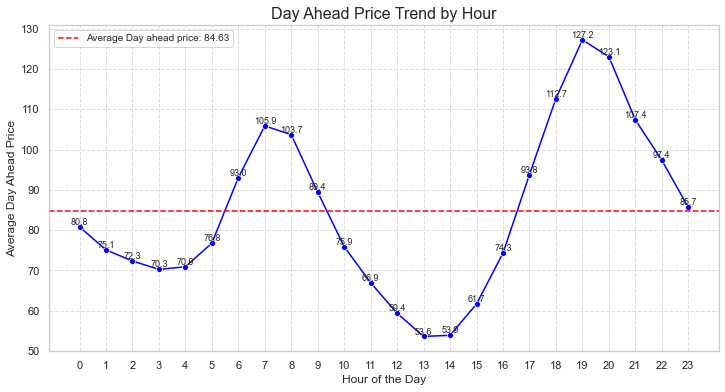

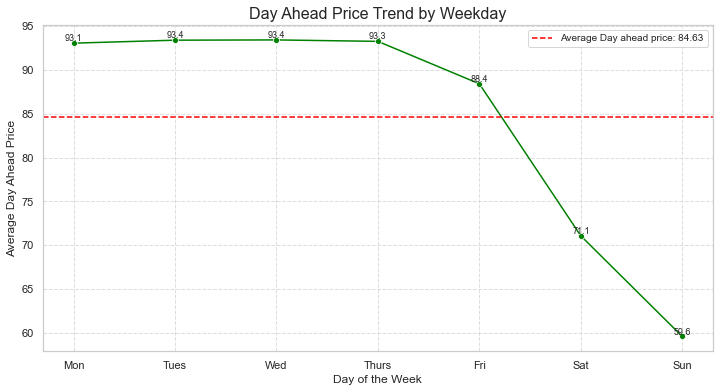

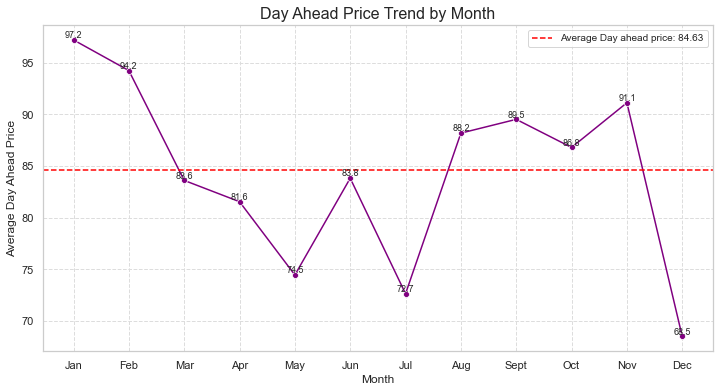

In [88]:
import matplotlib.pyplot as plt

# Grouping data by 'hour', 'week_day', and 'month' to calculate the average 'Day ahead price'
hourly_trend = final_df.groupby('hour')['Day ahead price'].mean()
weekday_trend = final_df.groupby('week_day')['Day ahead price'].mean()
monthly_trend = final_df.groupby('month')['Day ahead price'].mean()

sns.set(style="whitegrid")

# Calculate overall average
overall_avg_price = final_df['Day ahead price'].mean()

# Hourly trend visualization
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='Day ahead price', data=final_df, estimator='mean', ci=None, marker='o', color='blue')
plt.axhline(overall_avg_price, color='red', linestyle='--', label=f'Average Day ahead price: {overall_avg_price:.2f}')
for x, y in hourly_trend.items():
    plt.text(x, y, f'{y:.1f}', fontsize=9, ha='center', va='bottom')
plt.title('Day Ahead Price Trend by Hour', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average Day Ahead Price', fontsize=12)
plt.xticks(range(0, 24, 1))  # Show every second hour for better readability
plt.legend(fontsize=10)
plt.grid(color='#ddd', linestyle='--')
plt.show()

# Weekday trend visualization
plt.figure(figsize=(12, 6))
sns.lineplot(x='week_day', y='Day ahead price', data=final_df, estimator='mean', ci=None, marker='o', color='green')
plt.axhline(overall_avg_price, color='red', linestyle='--', label=f'Average Day ahead price: {overall_avg_price:.2f}')
for x, y in weekday_trend.items():
    plt.text(x, y, f'{y:.1f}', fontsize=9, ha='center', va='bottom')
plt.title('Day Ahead Price Trend by Weekday', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Average Day Ahead Price', fontsize=12)
plt.xticks(range(7), ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.legend(fontsize=10)
plt.grid(color='#ddd', linestyle='--')
plt.show()

# Monthly trend visualization
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='Day ahead price', data=final_df, estimator='mean', ci=None, marker='o', color='purple')
plt.axhline(overall_avg_price, color='red', linestyle='--', label=f'Average Day ahead price: {overall_avg_price:.2f}')
for x, y in monthly_trend.items():
    plt.text(x, y, f'{y:.1f}', fontsize=9, ha='center', va='bottom')
plt.title('Day Ahead Price Trend by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Day Ahead Price', fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])  # Show months (1-12)
plt.legend(fontsize=10)
plt.grid(color='#ddd', linestyle='--')
plt.show()

In [89]:
# Step 2: Feature selection based on correlation
corr_matrix = final_df.corr()
corr_target = corr_matrix["Day ahead price"].drop("Day ahead price")
selected_features = corr_target[abs(corr_target) > 0.0].index.tolist()

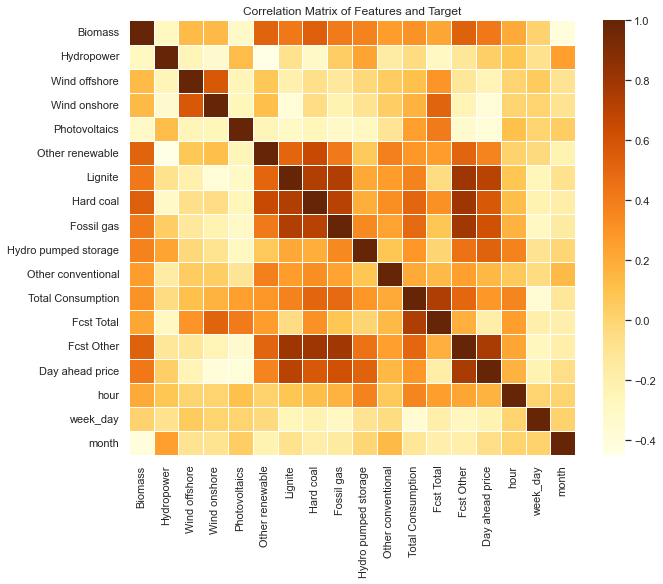

In [90]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap="YlOrBr", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features and Target")
plt.show()

In [91]:
# Define X (features) and y (target)
X = final_df[selected_features]
y = final_df["Day ahead price"]

In [92]:
# Split into training and test sets
last_day = final_df.index[-1].date()

# Train data: all rows except the last day
X_train = X[final_df.index.date != last_day]
y_train = y[final_df.index.date != last_day]

# Test data: all rows from the last day
X_test = X[final_df.index.date == last_day]
y_test = y[final_df.index.date == last_day]

# Confirm the new splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16054, 17), (24, 17), (16054,), (24,))

In [93]:
X_train

,Biomass,Hydropower,Wind offshore,Wind onshore,Photovoltaics,Other renewable,Lignite,Hard coal,Fossil gas,Hydro pumped storage,Other conventional,Total Consumption,Fcst Total,Fcst Other,hour,week_day,month
Start date,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,4365.00,1275.25,3059.25,28710.50,1.25,129.50,3859.25,2067.50,1721.75,42.75,1228.75,38346.00,56012.0,17018.25,0,6,1
2023-01-01 01:00:00,4344.75,1226.50,3586.00,29305.00,1.00,129.00,3866.50,2052.00,1568.00,126.75,1218.25,37777.25,56152.0,17417.25,1,6,1
2023-01-01 02:00:00,4333.00,1222.50,3842.25,29266.00,1.25,129.00,3860.25,2034.25,1571.50,85.50,1211.50,36939.75,53669.0,15134.75,2,6,1
2023-01-01 03:00:00,4338.75,1223.25,3463.25,27008.50,1.00,129.00,3864.75,2037.00,1564.75,84.00,1211.75,35932.50,52712.0,14860.75,3,6,1
2023-01-01 04:00:00,4353.25,1244.00,3462.25,26438.75,1.50,128.25,3841.00,2040.25,1550.50,84.00,1214.25,35486.25,51940.0,14610.75,4,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-30 19:00:00,4489.75,1987.75,1552.25,4689.25,0.00,86.25,12781.50,7216.00,10881.00,3294.50,1223.75,60477.25,47719.0,41577.25,19,2,10
2024-10-30 20:00:00,4485.25,1745.00,1501.25,4592.50,0.00,85.00,12389.75,7086.25,10179.00,1595.00,1224.75,57740.50,44601.0,39094.75,20,2,10
2024-10-30 21:00:00,4475.75,1676.25,1453.25,4419.25,0.00,85.00,12266.00,6899.75,9227.75,434.25,1222.50,54110.75,42303.0,37416.50,21,2,10


In [94]:
# Step 3: Train and evaluate multiple models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "Ridge Regression": Ridge(alpha=1.0),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

In [95]:
performance_metrics = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    performance_metrics.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})

In [96]:
performance_metrics

[{'Model': 'Linear Regression',
  'MAE': 9.699240416702787,
  'RMSE': 11.73706801915181,
  'R2': 0.5517615094637489},
 {'Model': 'Random Forest',
  'MAE': 14.624349999999984,
  'RMSE': 16.550771397380032,
  'R2': 0.10869491464931658},
 {'Model': 'Ridge Regression',
  'MAE': 9.699252388371761,
  'RMSE': 11.737089114264386,
  'R2': 0.5517598982180952},
 {'Model': 'Gradient Boosting',
  'MAE': 13.918792708170097,
  'RMSE': 15.7194499841255,
  'R2': 0.1959841755264773}]

### predicting with the best model

In [97]:
# As we can notice from the performance metrics of different models used. 
# Considering the errors to reduce between Actual price and Predicted price, let's take MAE to judge the best model to test.

# So, let's test with Ridge Regression as it gave the least MAE.

model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train, y_train)
y1_pred = model_ridge.predict(X_test)



In [98]:
# Creating a DataFrame to store the results
last_day_results = pd.DataFrame({
    "Date-Time": X_test.index,
    "Actual Price": y_test.values,
    "Predicted Price": y1_pred
})

# Resetting the index for better readability
last_day_results.set_index("Date-Time", inplace=True)
last_day_results.index = pd.to_datetime(last_day_results.index)

last_day_results.sort_index()

last_day_results

,Actual Price,Predicted Price
Date-Time,,
2024-10-31 00:00:00,105.16,105.468294
2024-10-31 01:00:00,98.51,103.019648
2024-10-31 02:00:00,96.58,99.148586
2024-10-31 03:00:00,94.81,97.475666
2024-10-31 04:00:00,98.03,98.706469
2024-10-31 05:00:00,102.34,101.932267
2024-10-31 06:00:00,121.15,114.128225
2024-10-31 07:00:00,135.53,131.108748
2024-10-31 08:00:00,133.47,124.036548


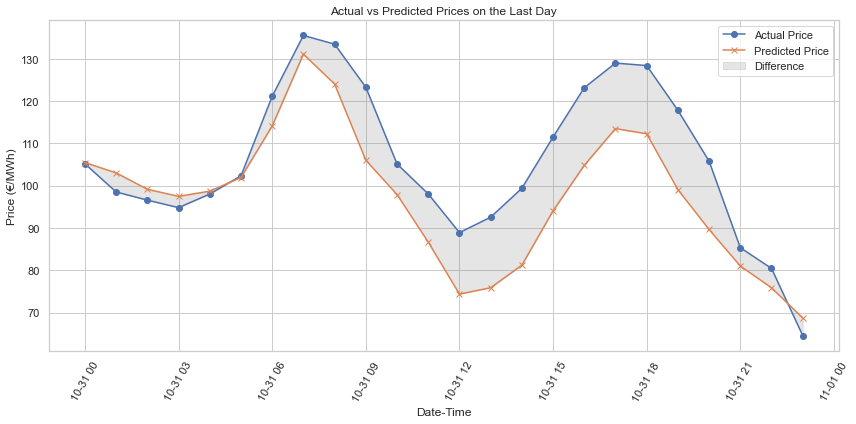

In [99]:
plt.figure(figsize=(12, 6))
plt.plot(last_day_results.index, last_day_results["Actual Price"], label="Actual Price", marker='o')
plt.plot(last_day_results.index, last_day_results["Predicted Price"], label="Predicted Price", marker='x')
plt.fill_between(
    last_day_results.index,
    last_day_results["Actual Price"],
    last_day_results["Predicted Price"],
    color='gray',
    alpha=0.2,
    label="Difference"
)
plt.title("Actual vs Predicted Prices on the Last Day")
plt.xlabel("Date-Time")
plt.ylabel("Price (€/MWh)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

## TO DO Ideas

* <b>[ In Process ]</b> Check the summary and trend of individual features to dig more on the seasonality. 

* <b>[ In Process ]</b> Create Lag features and rolling means (Feature Engineering) for better modeling.

* Include other datasets like balancing and costs, but after the understanding of its importance in the market prices.

* <b>[ Pending Data ]</b> Gather Weather data, if possible, in hourly basis to merge with our datasets.